In [11]:
import numpy   as np
import pandas  as pd
import seaborn as sns

import df_visualizations as dv
import remap_values as rv

import zillow_functions as zf

import matplotlib.pyplot as plt

import pickle

from sklearn.utils           import shuffle

from sklearn.model_selection import GridSearchCV

from sklearn.linear_model    import ElasticNet
from sklearn.svm             import SVR
from sklearn.ensemble        import RandomForestRegressor
from sklearn.neural_network  import MLPRegressor

In [2]:
%matplotlib inline
plt.style.use( 'dark_background' )
plt.rcParams['figure.figsize'] = (14,10)

In [21]:
prop  = pd.read_csv( 'data/properties_2016.csv' )
trans = pd.read_csv( 'data/train_2016_v2.csv'   )

my_df = pd.merge( prop, trans, on='parcelid', how='inner' )

del prop
del trans

In [22]:
my_df = zf.build_data( my_df )
my_df = zf.scale_data( my_df )

In [23]:
my_df.head(10)

,parcelid,logerror,has_ac,has_spa,has_pool,unit_single,unit_double,unit_multi,tax_delinquent,building_quality_low,...,day_of_week_norm,age_scaled,log_pool_sqft_scaled,log_unit_sqft_scaled,log_lot_sqft_scaled,log_garage_sqft_scaled,log_n_bath_scaled,n_rooms_scaled,tax_pca_0,tax_pca_1
0,17073783,0.0953,0,0,0,1,0,0,0,0,...,-1.000000,-0.737123,-24.553923,-0.524475,-1.932307,-31.842940,-0.327270,-0.800000,1.294381,-0.483059
1,17088994,0.0198,0,0,0,1,0,0,0,0,...,-1.000000,-0.907777,-24.553923,-1.740257,-0.197046,-31.842940,-1.074487,-1.333333,0.729424,-0.529121
2,17100444,0.0060,0,0,0,1,0,0,0,0,...,-0.333333,0.542778,-24.553923,-0.869548,-0.308905,-0.476054,-0.533097,-0.800000,4.622292,-0.446284
3,17102429,-0.0566,0,0,0,1,0,0,0,0,...,1.000000,0.158808,-24.553923,-0.008085,-0.163631,-0.259323,-0.776539,-0.800000,4.053930,-0.612812
4,17109604,0.0573,0,0,0,1,0,0,0,0,...,0.666667,-0.651796,-24.553923,1.094538,-0.354874,1.635116,-0.327270,0.800000,-1.298297,-0.411419
5,17125829,0.0564,0,0,0,1,0,0,0,0,...,-0.333333,-0.481143,-24.553923,1.536809,0.203599,-0.116121,-0.327270,0.800000,0.344215,-1.112824
6,17132911,0.0315,0,0,0,1,0,0,0,0,...,-0.333333,-0.395816,-24.553923,0.320188,-0.059588,-0.181720,-0.533097,-0.266667,-1.053835,0.128166
7,17134926,0.0257,0,0,1,1,0,0,0,0,...,-1.000000,-0.097173,1.821285,1.309792,-0.130786,-0.487718,-0.327270,0.800000,-1.400685,-0.731834
8,17139988,0.0020,0,0,0,1,0,0,0,0,...,-1.000000,-0.438480,-24.553923,-0.469706,-0.162807,0.107110,-0.533097,-0.266667,-0.870387,-0.364520
9,17167359,-0.0576,0,0,0,1,0,0,0,0,...,-0.333333,0.798758,-24.553923,-0.295941,-0.419399,-3.328723,-1.074487,-0.266667,0.399455,-0.216099


In [119]:
# Train on 80% of the data

frac_train = 0.8

train_index = int( my_df.shape[0] * frac_train )


# Shuffle it all
shuffle_df = shuffle( my_df, random_state=0 ).drop( 'parcelid', axis=1 )


train_x = shuffle_df.loc[ :train_index  ].drop( ['logerror'], axis=1 ).values
test_x  = shuffle_df.loc[  train_index: ].drop( ['logerror'], axis=1 ).values

train_y = shuffle_df.loc[ :train_index  ]['logerror'].values
test_y  = shuffle_df.loc[  train_index: ]['logerror'].values

#train_y = 10**shuffle_df.loc[ :train_index  ]['logerror'].values
#test_y  = 10**shuffle_df.loc[  train_index: ]['logerror'].values

In [113]:
a = np.array([-5,-1,-0.5,0.0,0.5,1,5])
print 10**(- abs(a) )

[  1.00000000e-05   1.00000000e-01   3.16227766e-01   1.00000000e+00
   3.16227766e-01   1.00000000e-01   1.00000000e-05]


In [121]:
# Root mean square log error
# Return 10**-abs(rmsle) for the way sklearn scores
def rmsle(reg, x, actual):
    predicted = reg.predict( x )
    assert(len(predicted) == len(actual))
    p = np.log(np.array(predicted) + 1)
    a = np.log(np.array(actual) + 1)
    rmsle = (((p - a)**2).sum() / len(predicted))**0.5
    return 10**( -abs(rmsle) )

def do_cv( reg, params, train_x, train_y, test_x, test_y, n_folds=5, score=rmsle ):
    
    gcv = GridSearchCV( reg, param_grid=params, cv=n_folds, scoring=score )
    
    gcv.fit( test_x, test_y )
    

    print 'Best score: ',gcv.best_score_,'\n'
    print gcv.best_params_,'\n'
    print 'Internal score: ',gcv.score( test_x, test_y ),'\n'
    print 'External score: ',gcv.score( test_x, test_y )

    pred = gcv.predict( test_x )
    
    lower=1e-3
    upper=1e4
    
    lower_x = 1e-3
    upper_x = 1e4
    
    predict = '10^(logerror)'
    
    plt.scatter( test_y, pred, color='b' )

    plt.xlim( lower_x, upper_x )
    plt.xscale('log')
    plt.xlabel( 'True Value '+predict )

    plt.ylim( lower  , upper   )
    plt.yscale('log')
    plt.ylabel( 'Predicted Value '+predict )
    
    plt.show()
    
    lower= -3
    upper=  3
    
    lower_x = -3
    upper_x =  4

    plt.scatter( np.log10( test_y ), np.log10( pred ) - np.log10( test_y ), color='b' )
    plt.xlim( lower_x, upper_x )
    plt.ylim( lower  , upper   )
    plt.xlabel( 'log_10( True Value )' )
    plt.ylabel( 'Diff log pred-true ' )
    plt.show()

    plt.scatter( np.log10( pred ), np.log10( pred ) - np.log10( test_y ), color='b' )
    plt.xlim( lower_x, upper_x )
    plt.ylim( lower  , upper   )
    plt.xlabel( 'log_10( Prediction )' )
    plt.ylabel( 'Diff log pred-true ' )
    plt.show()

    return gcv

def do_exp_cv( reg, params, train_x, train_y, test_x, test_y, n_folds=5, score='r2' ):
    
    gcv = GridSearchCV( reg, param_grid=params, cv=n_folds, scoring=score )
    
    gcv.fit( test_x, test_y )
    

    print 'Best score: ',gcv.best_score_,'\n'
    print gcv.best_params_,'\n'
    print 'Internal score: ',gcv.score( test_x, test_y ),'\n'
    print 'External score: ',gcv.score( test_x, test_y )

    pred = gcv.predict( test_x )
    
    lower=1e-3
    upper=1e4
    
    lower_x = 1e-3
    upper_x = 1e4
    
    predict = '10^(logerror)'
    
    plt.scatter( test_y, pred, color='b' )

    plt.xlim( lower_x, upper_x )
    plt.xscale('log')
    plt.xlabel( 'True Value '+predict )

    plt.ylim( lower  , upper   )
    plt.yscale('log')
    plt.ylabel( 'Predicted Value '+predict )
    
    plt.show()
    
    lower= -3
    upper=  3
    
    lower_x = -3
    upper_x =  4

    plt.scatter( np.log10( test_y ), np.log10( pred ) - np.log10( test_y ), color='b' )
    plt.xlim( lower_x, upper_x )
    plt.ylim( lower  , upper   )
    plt.xlabel( 'log_10( True Value )' )
    plt.ylabel( 'Diff log pred-true ' )
    plt.show()

    plt.scatter( np.log10( pred ), np.log10( pred ) - np.log10( test_y ), color='b' )
    plt.xlim( lower_x, upper_x )
    plt.ylim( lower  , upper   )
    plt.xlabel( 'log_10( Prediction )' )
    plt.ylabel( 'Diff log pred-true ' )
    plt.show()

    return gcv

Best score:  0.441431778839 

{'max_features': 'auto', 'min_samples_split': 50, 'n_estimators': 20} 

Internal score:  0.523816550013 

External score:  0.523816550013


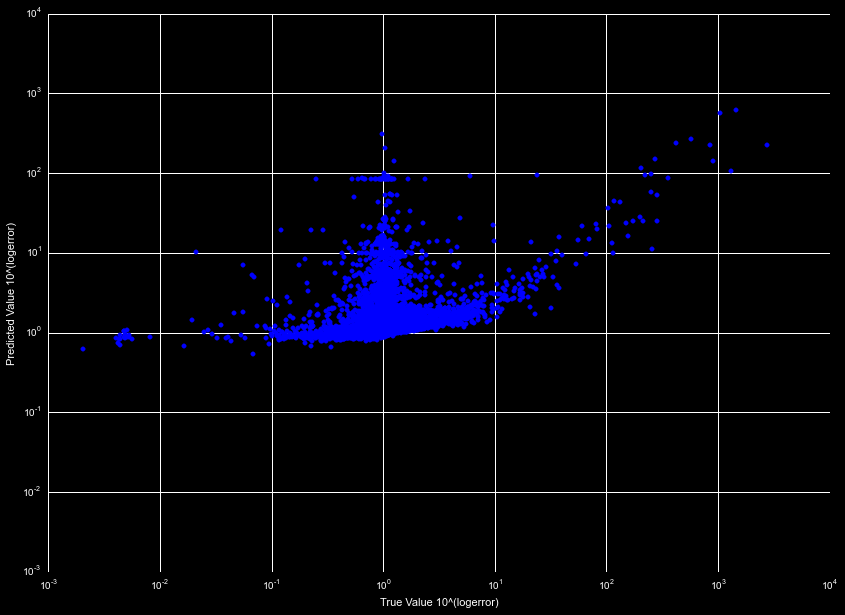

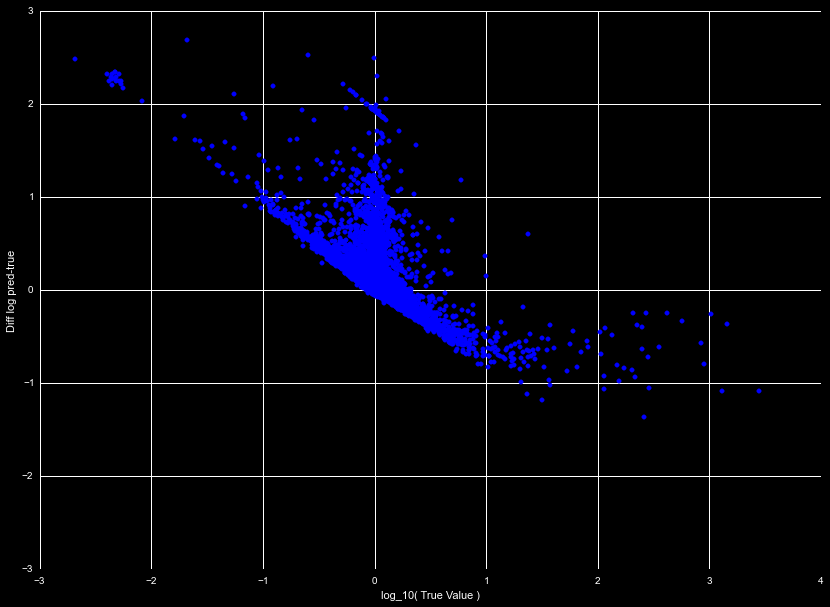

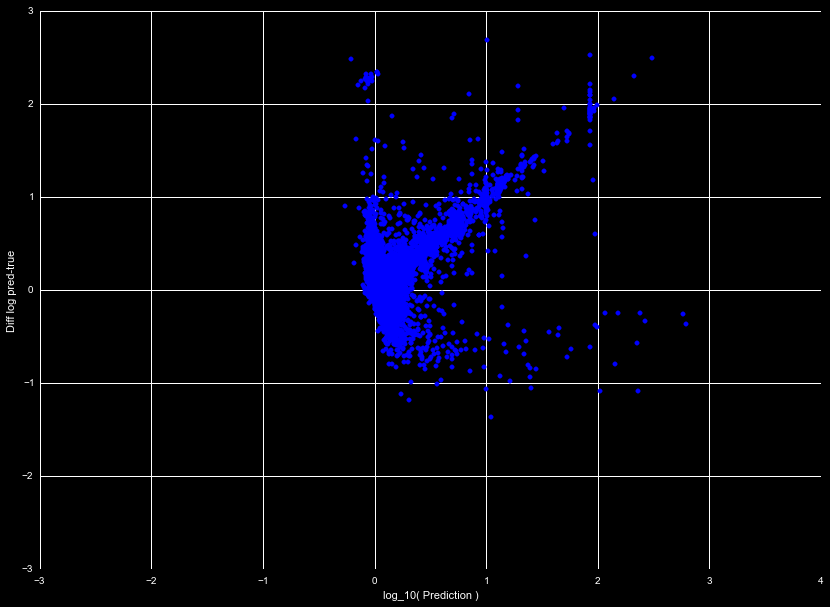

In [115]:
params = {
            'n_estimators':[20,50],
            'min_samples_split':[20,50,80],
            'max_features':['auto']
         }

rf_reg = do_cv( RandomForestRegressor(), params, train_x, train_y, test_x, test_y, n_folds=3 )

Best score:  -0.00187751308734 

{'alpha': 0.001, 'activation': 'logistic', 'hidden_layer_sizes': 10} 

Internal score:  0.0032193869741 

External score:  0.0032193869741


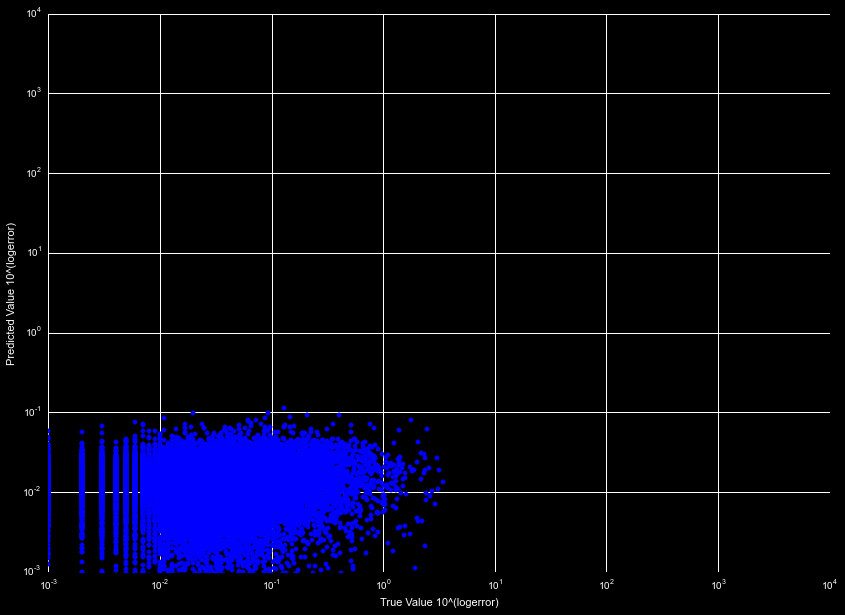

/home/sean/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in log10
/home/sean/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:51: RuntimeWarning: invalid value encountered in log10


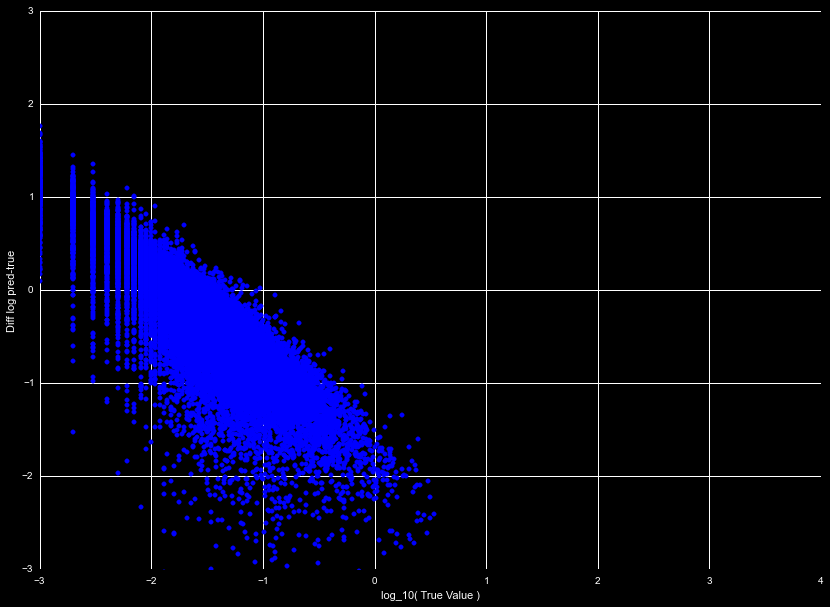

/home/sean/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:58: RuntimeWarning: invalid value encountered in log10
/home/sean/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:58: RuntimeWarning: divide by zero encountered in log10


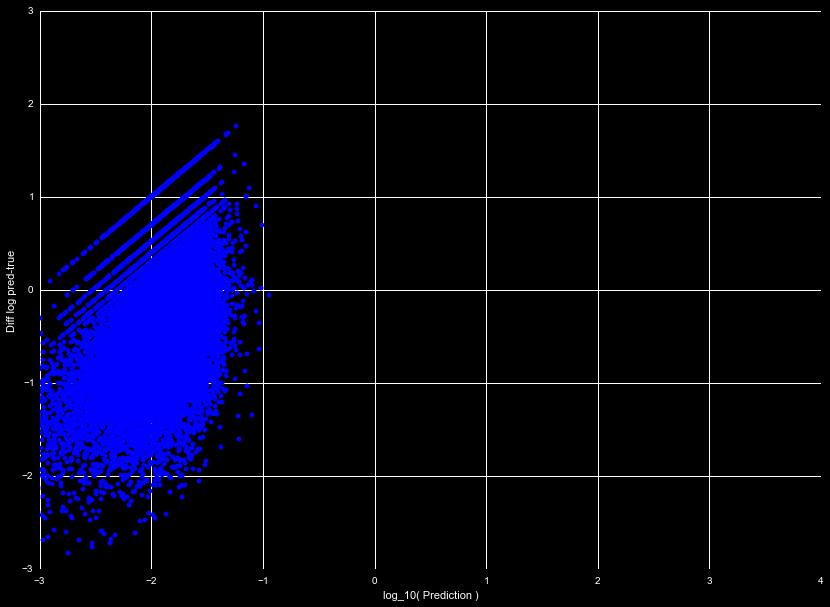

In [122]:
params = {
            'hidden_layer_sizes':[(10)],#(20,),(50,),(10,10),(20,20),(50,50)],
            'activation':['logistic','tanh'],
            'alpha':[1e-3,1e-1]
         }

nn_reg = do_cv( MLPRegressor(), params, train_x, train_y, test_x, test_y, n_folds=3 )